# Data exploration


#####  Response association with clusters analysis - 
Each cluster see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.

##### Response association with GEP
1) Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

2) Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats

Helper functions:

In [2]:
def print_pvals(pvals, n_groups):
    plt.figure(figsize=(8, 6), dpi=80);
    min_pval = 0.05

    small_pvals = pvals[pvals[:,1]<min_pval]
    big_pvals = pvals[pvals[:,1]>=min_pval]


    plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1]);
    plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1]);

    ax = plt.plot([0,n_groups+1],[min_pval,min_pval], color='y');
    plt.xticks(np.arange(1, n_groups+1));
    plt.yticks([min_pval, 1]);
    plt.xlim((0,n_groups+1));
    plt.title('p-values');

    for coord in pvals:
        plt.text(coord[0], coord[1], '{}'.format(int(coord[0])));
        
def get_coorected_label(x ,p_value_dic):
    pvalue = p_value_dic[x]
    return str(x) + '\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if pvalue < sig])

def save_pvals(path, pvals, corrected_pvals, GROUP_NAME):
    pval_df = pd.DataFrame(np.array([pvals[:,0], pvals[:,1], corrected_pvals[:,1]]).T, columns=[GROUP_NAME, 'pval', 'corrected_pval'])#.sort_values('pval')
    pval_df[GROUP_NAME] = pval_df[GROUP_NAME].astype(int)
    pval_df.to_excel(path, index=False)


### Specify clinical table and set output path
clinical table can be 1|2|3
* 1 - NR mucosal vs NR cutaneous
* 2 - NR mucosal vs R cutaneous
* 3 - NR mucosal vs NR & R cutaneous

OUTPUT PATH - all marker list/heatmaps/figures will be saved there

In [3]:
# FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21/4.1.22/NR_mucosal_vs_R_cutaneous'
# CLINICAL_TABLE_NUM = 2

# create_folder(FOLDER_PATH)

##### Loads clinical table to get labels - R/NR

In [4]:
# melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM) #
melanoma_clinical_data = get_clinical_data(71)#ICI=True, after_biopsy='ICI')
melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['ICI']]
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
display(melanoma_clinical_data.head(20))#.reset_index().drop(columns=['index', 'level_0']))
res_melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv
Num of samples in table is 53


,Patient id,Melanoma type,response,prior to biopsy,after biopsy,ICI,BRAF
0,M97,Cutaneous,R,nothing,ICI,True,False
1,M98,Cutaneous,R,ICI,other therapy,True,False
2,M99,Mucosal,NR,ICI,other immune therapy,True,False
3,M100,Cutaneous,NR,ICI,nothing,True,False
4,M101,other,R,nothing,ICI,True,False
5,M102,other,NR,ICI,ICI,True,False
7,M104,Cutaneous,NR,ICI,nothing,True,False
8,M105,other,NR,ICI,ICI,True,False
9,M106,Cutaneous,NR,ICI,other immune therapy,True,False
10,M107,Cutaneous,NR,ICI,other immune therapy,True,False


NR                    31
R                     18
not in use for now     4
Name: response, dtype: int64

In [5]:
# Counter(res_melanoma_clinical_data['ICI'])
# res_melanoma_clinical_data[['ICI', 'response']]
Counter(res_melanoma_clinical_data[res_melanoma_clinical_data['response']!='not in use for now']['ICI'])

Counter({True: 49})

#### Builds response/non_response sample list

In [6]:
response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'R']['Patient id'].tolist()
non_response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'NR']['Patient id'].tolist()
no_used_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'not in use for now']['Patient id'].tolist()

print(f'number reponse_samples: {len(response_samples)}')
print(f'number non_reponse_samples: {len(non_response_samples)}')
print(f'number no label samples: {len(no_used_samples)}')

number reponse_samples: 18
number non_reponse_samples: 31
number no label samples: 4


#### Loads tumor & immune cohort:

In [7]:
# # tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
# # COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/16.3.22/immune_cells_normalized_16.3.22_4k_genes.pkl'

# # tumor_cohort = pickle.load(open(tumor_path, 'rb'))
immune_cohort = pickle.load(open(COHORT_PATH, 'rb'))
# tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)
# immune_cohort = cohort.filter_cells_by_property('is_immune', True)

#  1. Response differential expression analysis

(1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

In [8]:
# response_samples_indices = [s in response_samples for s in tumor_cohort.samples]
# non_response_samples_indices =[s in non_response_samples for s in tumor_cohort.samples]
# no_used_samples_indices = [s in no_used_samples for s in tumor_cohort.samples]

# print(f'number of cells in response_samples_indices: {sum(response_samples_indices)}')
# print(f'number of cells in non_response_samples_indices: {sum(non_response_samples_indices)}')
# print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

# response_samples_tumor_cells = tumor_cohort[response_samples_indices]
# non_response_samples_tumor_cells = tumor_cohort[non_response_samples_indices]

# 2. Response association with clusters analysis

For each cluster, see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.


In [9]:
# clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

##### Takes only samples that appear in the clinical table

In [10]:
clusters_barcodes_mapping_df = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df["Sample"].isin(melanoma_clinical_data['Patient id'])]

###### cluster visualizations

In [11]:
df = clusters_barcodes_mapping_df#.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']

In [12]:
clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


RanksumsResult(statistic=0.6350852961085883, pvalue=0.5253727863737021)
WilcoxonResult(statistic=28.0, pvalue=0.423828125)


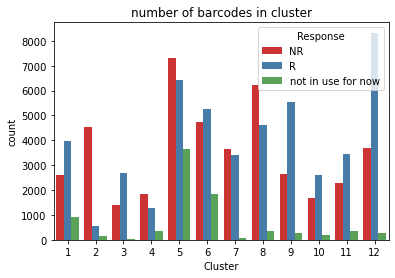

In [13]:
# for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
#     print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Response', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(R_counts, NR_counts))
print(wilcoxon(R_counts, NR_counts))

##### Normalized by group size (number of barcodes in group - R/NR):

Normalized by number of barcodes in group (R/NR):

RanksumsResult(statistic=0.1732050807568877, pvalue=0.8624902301359216)
WilcoxonResult(statistic=36.0, pvalue=0.85009765625)


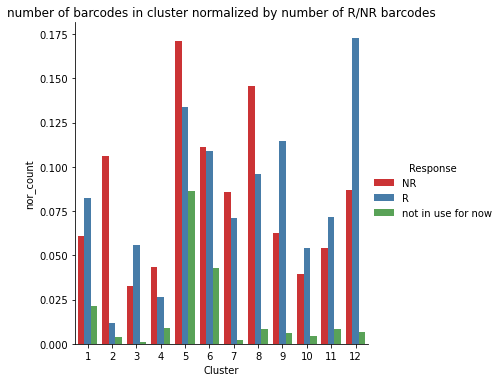

In [14]:
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR

print('Normalized by number of barcodes in group (R/NR):')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')
    
print()
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=1.5588457268119895, pvalue=0.11903289845700783)
WilcoxonResult(statistic=25.0, pvalue=0.30126953125)


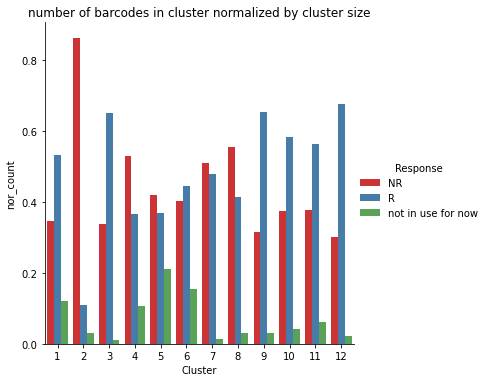

In [15]:
NR_nor = NR_counts/(NR_counts + R_counts)
R_nor = R_counts/(NR_counts + R_counts)

# print('Normalized by number of barcodes in cluster:')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')
    
df_nor_count = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
# df_nor_count = df[df["Response"]!= 'not in use for now'].groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

# 2.1. patient fraction over clusters - ranksum test

In [16]:
clusters = clusters_barcodes_mapping_df['Cluster'].unique()
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index()#.drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['Cluster'])#.drop(columns=['index'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

See how many samples (R/NR) have cells in each cluster:

In [17]:
# sample_fractions_df[["Sample", 'Cluster']].groupby('Cluster').count()
# sample_fractions_df[["Sample", 'Cluster', 'Response']].groupby(['Cluster','Response']).count()

Add zero fraction samples to DF:

<Figure size 480x240 with 0 Axes>

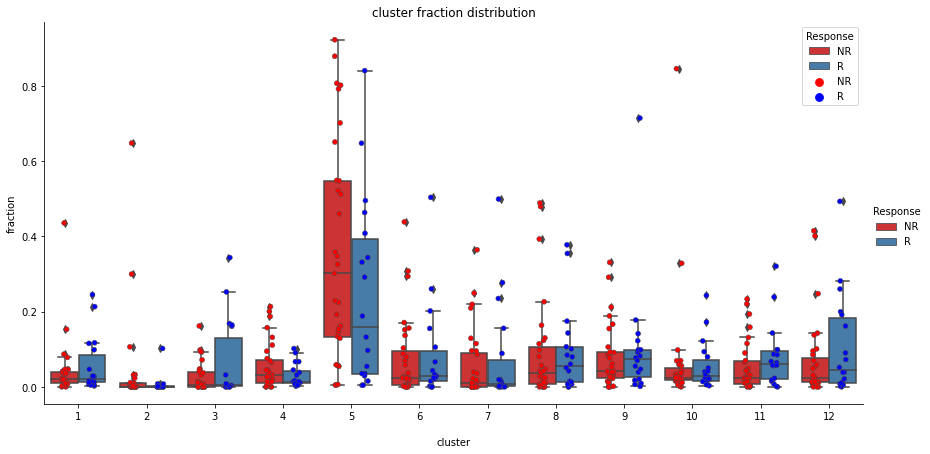

In [18]:
sample_fractions_df = sample_fractions_df[["Sample", 'Cluster', 'fraction' , 'Response' ]]
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    
pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

fig = plt.figure(figsize=(6, 3), dpi=80);
sns.reset_orig();
full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
full_sample_fractions_df = full_sample_fractions_df.sort_values('Cluster')
ax = sns.catplot(kind="box", x='cluster', y='fraction', hue='Response', data=full_sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution");
sns.stripplot(x='cluster', y='fraction', hue='Response', data=full_sample_fractions_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
# print_pvals(pvals, len(set(sample_fractions_df["Cluster"])))
# pvals


In [19]:
directonality_df = full_sample_fractions_df.groupby(['Cluster', 'Response']).median().reset_index().pivot_table(index=['Cluster'], values='fraction', columns=['Response'])[['NR','R']]
directonality_df['cluster association'] = np.array(['NR', 'R'])[directonality_df.values.argmax(1)]
# directonality_df

In [20]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# save_pvals(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'cluster')
# ax.savefig(join(OUTPUT_PATH, 'cluster_fractions_ranksum_test.png'), dpi = 150)

In [21]:
# pd.set_option('display.max_rows', None)
# cluster_idx = 1
# full_sample_fractions_df[full_sample_fractions_df['Cluster']==cluster_idx].sort_values('fraction')#['Response'].tolist()

# plan train strategy 

In [20]:
clusters_barcodes_mapping_df

,Unnamed: 0,Sample,Barcode,Cluster,Response
0,0,M100,AACACGTCAGCTGCAC-1,4,NR
1,0,M100,AACCGCGAGCGATCCC-1,5,NR
2,0,M100,AACGTTGGTTCGTGAT-1,7,NR
3,0,M100,AACTCCCAGAGGGCTT-1,7,NR
4,0,M100,AAGCCGCTCAACGGGA-1,5,NR
...,...,...,...,...,...
131883,58457,M169,TTTGTCATCCTCAATT-1,12,R
131884,58458,M169,TTTGTCATCCTGTACC-1,9,R
131885,58459,M169,TTTGTCATCTATCCCG-1,12,R
131886,58460,M169,TTTGTCATCTCTAAGG-1,12,R


In [59]:
ml_melanoma_clinical_data = melanoma_clinical_data.copy()
ml_melanoma_clinical_data = ml_melanoma_clinical_data[ml_melanoma_clinical_data.ICI]
ml_melanoma_clinical_data = ml_melanoma_clinical_data[(ml_melanoma_clinical_data.response=='R') | (ml_melanoma_clinical_data.response=='NR' )]

In [85]:
train_set_clinical_df = ml_melanoma_clinical_data[ml_melanoma_clinical_data['Patient id'].apply(lambda x: int(x[1:])<147)]
test_set_clinical_df = ml_melanoma_clinical_data[ml_melanoma_clinical_data['Patient id'].apply(lambda x: int(x[1:])>146)]


print('Train set')
print(train_set_clinical_df['response'].value_counts())
print('\n\nTest set')
print(test_set_clinical_df['response'].value_counts())

Train set
NR    24
R     12
Name: response, dtype: int64


Test set
NR    7
R     6
Name: response, dtype: int64


In [87]:
train_cluster_barcode_mapping = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df.Sample.isin(train_set_clinical_df['Patient id'])].drop(columns='Unnamed: 0')
test_cluster_barcode_mapping = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df.drop(columns='Unnamed: 0').Sample.isin(test_set_clinical_df['Patient id'])].drop(columns='Unnamed: 0')

n_barcodes_train_df = train_cluster_barcode_mapping.groupby(['Sample', 'Cluster', 'Response']).count().reset_index()
n_barcodes_test_df = test_cluster_barcode_mapping.groupby(['Sample', 'Cluster', 'Response']).count().reset_index()

See distribution of the number of barcodes in train samples: 

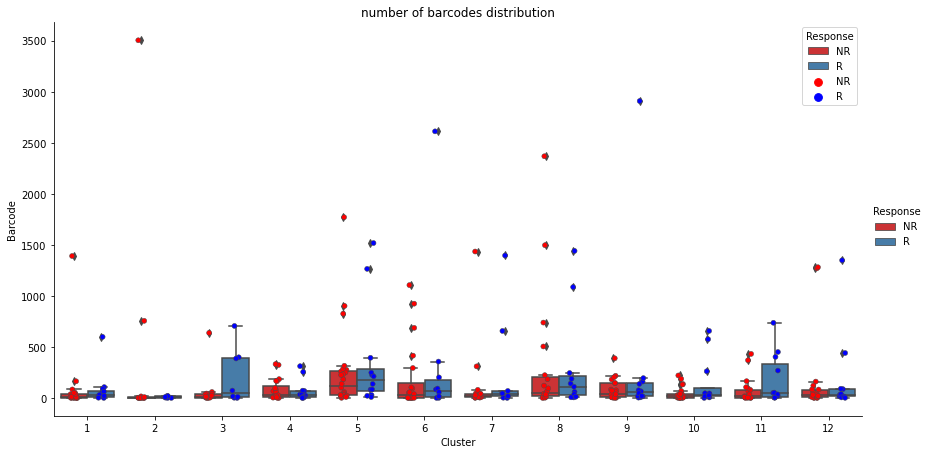

In [84]:
ax = sns.catplot(kind="box", x='Cluster', y='Barcode', hue='Response', data=n_barcodes_train_df, palette="Set1",height=6, aspect=2.0).set(title="number of barcodes distribution");
sns.stripplot(x='Cluster', y='Barcode', hue='Response', data=n_barcodes_train_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});

# Select samples for the train process
in each sample we have a certain amount of cells belonging to each of the clusters. Since we want the train set to be balanced, and not to have different amount of cells for each sample, we need to pick a minimum value of barcodes in cluster for a sample to be consider as part of the training set. Therefore, we look over the samples and see how many cells each of them have associated with the cluster, and that way we can select a threshold, so that we will have the maximun number of barcodes for training and at the same time as many as possible different samples to maintain genetic variablity.

,num of samples will be taken,num of barcodes in each sample,total barcodes for train,Response,% improvement
0,5,370,1850,NR,1.146221
1,6,269,1614,R,1.397403
2,7,165,1155,NR,1.336806
3,9,96,864,NR,1.080000
4,10,80,800,NR,1.101928
5,11,66,726,NR,1.116923
6,13,50,650,R,1.203704
7,15,36,540,R,1.534091
8,16,22,352,R,1.157895
9,19,16,304,NR,1.169231


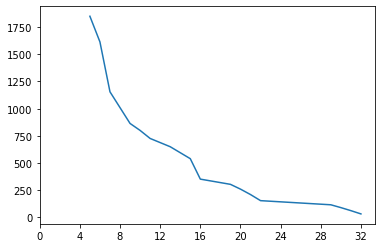

In [108]:
pd.set_option('display.max_rows', None)
cluster_idx = 11


s1 = n_barcodes_train_df[n_barcodes_train_df.Cluster==cluster_idx].sort_values('Barcode').reset_index(drop= True)
s2 = pd.DataFrame(transpose_list([np.arange(1,len(s1.Barcode)+1)[ : :-1], s1.Barcode, s1.Barcode * len(s1) - (np.arange(len(s1.Barcode))*s1.Barcode), s1.Response]),
            columns=['num of samples will be taken', 'num of barcodes in each sample', 'total barcodes for train', 'Response'])
s2.drop_duplicates(subset ="num of barcodes in each sample",
                     keep = 'first', inplace = True)
s2.drop_duplicates(subset = 'total barcodes for train',
                     keep = 'first', inplace = True)
s2 = s2.reset_index(drop=True)#.set_index('num_of_samples')

def bigger_value_before_in_df_iter(x):
    if x==0:
        return True
    return max(s2.iloc[:x]['total barcodes for train']) <= s2.iloc[x,:]['total barcodes for train']
s2 = s2[s2.apply(lambda x: bigger_value_before_in_df_iter(x.name), axis=1)]


s2['% improvement'] = [1] + list(s2['total barcodes for train'][1:] / s2['total barcodes for train'][:-1].values)


s2 = s2.iloc[::-1].reset_index(drop=True)


plt_s_from = 0
plt.plot(s2.iloc[plt_s_from:]['num of samples will be taken'], s2.iloc[plt_s_from:]['total barcodes for train'])
plt.xticks(np.arange(plt_s_from, max(s2['num of samples will be taken'])+1, 4));
s2

In [109]:
# cluster_idx = 2
# n_barcodes_train_df[n_barcodes_train_df.Cluster==cluster_idx].sort_values('Barcode', ascending=False).reset_index(drop=True)

# Create mapping of barcodes to train validation and test:

In [234]:
protocol_path = r'/storage/md_keren/shitay/Data/tables/ML/split_into_test_val_train_sets/immune_clusters_n_barcodes_each_sample.xlsx'
output_path = r'/storage/md_keren/shitay/Data/tables/ML/split_into_test_val_train_sets/cluster_mapping'
protocol_df = pd.read_excel(protocol_path)

In [289]:
deviation = 0.12

pd.set_option('display.max_rows', 10)


for idx, row in protocol_df.iterrows():
    curr_cluster_barcode_mapping = train_cluster_barcode_mapping[train_cluster_barcode_mapping.Cluster == row.cluster]

    #  value of barcodes for model (min threshold: protocol_min_value * (1-deviation),    max threshold: protocol_min_value * (1+deviation))
    min_n_barcodes = int(row.n_barcodes_in_each_sample * (1-deviation))
    max_n_barcodes = int(row.n_barcodes_in_each_sample * (1+deviation))

    # Create a list of patients in train/validation sets
    curr_n_barcodes_train_df = n_barcodes_train_df[n_barcodes_train_df.Cluster==row.cluster].rename(columns={'Barcode':'n_barcode'})
    train_cluster_samples = curr_n_barcodes_train_df[curr_n_barcodes_train_df.n_barcode >= min_n_barcodes].Sample
    validation_cluster_samples = curr_n_barcodes_train_df[curr_n_barcodes_train_df.n_barcode < min_n_barcodes].Sample

    # define a random train set for this cluster and save an excel of barcode-mapping
    samples_filtered_curr_cluster_barcode_mapping = curr_cluster_barcode_mapping[curr_cluster_barcode_mapping.Sample.isin(train_cluster_samples)]
    train_set_barcode_mapping = samples_filtered_curr_cluster_barcode_mapping.groupby(['Sample']).apply(lambda grp: grp.sample(n=min(grp.count().Barcode, max_n_barcodes))).reset_index(drop=True)

    # all cells in validation/test samples will be taken
    validation_set_barcodes = curr_cluster_barcode_mapping[curr_cluster_barcode_mapping.Sample.isin(validation_cluster_samples)]
    test_set_barcodes = test_cluster_barcode_mapping[test_cluster_barcode_mapping.Cluster==row.cluster].reset_index(drop=True)

    # save
    train_set_barcode_mapping.to_excel(join(output_path, f'cluster_{row.cluster}_train_barcodes.xlsx'), index=False)
    validation_set_barcodes.to_excel(join(output_path, f'cluster_{row.cluster}_validation_barcodes.xlsx'), index=False)
    test_set_barcodes.to_excel(join(output_path, f'cluster_{row.cluster}_test_barcodes.xlsx'), index=False)

# DEBUG

In [331]:
##### crerate a dummy for local debug

In [358]:
split_data_path = r'/storage/md_keren/shitay/Data/tables/ML/split_into_test_val_train_sets/cluster_mapping'
OUT_PATH = r'/storage/md_keren/shitay/outputs/ML/DEBUG/'

for cluster_number in range(1,13):
    print(cluster_number)
    train_set_barcode_mapping = pd.read_excel(join(split_data_path, f'cluster_{cluster_number}_train_barcodes.xlsx'))
    test_set_barcode_mapping = pd.read_excel(join(split_data_path, f'cluster_{cluster_number}_test_barcodes.xlsx')).sample(100)
    try:
        validation_set_barcode_mapping = pd.read_excel(join(split_data_path, f'cluster_{cluster_number}_validation_barcodes.xlsx')).sample(100)
    except:
        print('a smaller set will be taken')
        validation_set_barcode_mapping = pd.read_excel(join(split_data_path, f'cluster_{cluster_number}_validation_barcodes.xlsx')).sample(10)
        
    
    
    train_cohort = immune_cohort.get_subset_by_identifiers(train_set_barcode_mapping.Sample, train_set_barcode_mapping.Barcode)
    test_cohort = immune_cohort.get_subset_by_identifiers(test_set_barcode_mapping.Sample, test_set_barcode_mapping.Barcode)
    validation_cohort = immune_cohort.get_subset_by_identifiers(validation_set_barcode_mapping.Sample, validation_set_barcode_mapping.Barcode)

    

    pkl_to_save = train_cohort + validation_cohort + test_cohort
    pickle.dump((pkl_to_save), open(join(OUT_PATH, f'debug_cohort_cluster_{cluster_number}.pkl'), 'wb'), protocol=4)
    
    
    # save barcodes
    train_set_barcode_mapping.to_excel(join(OUT_PATH, f'cluster_{cluster_number}_train_barcodes.xlsx'))
    test_set_barcode_mapping.to_excel(join(OUT_PATH, f'cluster_{cluster_number}_test_barcodes.xlsx'))
    validation_set_barcode_mapping.to_excel(join(OUT_PATH, f'cluster_{cluster_number}_validation_barcodes.xlsx'))

1
2
a smaller set will be taken
3
a smaller set will be taken
4
5
6
7
8
9
10
a smaller set will be taken
11
12


In [23]:
split_data_path = r'/storage/md_keren/shitay/Data/tables/ML/split_into_test_val_train_sets/cluster_mapping'
OUT_PATH = r'/storage/md_keren/shitay/outputs/ML/DEBUG/'


accu_train_df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster', 'Response'])
accu_test_df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster', 'Response'])
accu_val_df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster', 'Response'])

for cluster_number in range(1, 13):
    print(cluster_number)
    train_set_barcode_mapping = pd.read_excel(join(split_data_path, f'cluster_{cluster_number}_train_barcodes.xlsx'))
    test_set_barcode_mapping = pd.read_excel(join(split_data_path, f'cluster_{cluster_number}_test_barcodes.xlsx'))
    try:
        validation_set_barcode_mapping = pd.read_excel(join(split_data_path, f'cluster_{cluster_number}_validation_barcodes.xlsx'))
    except:
        print('a smaller set will be taken')
        validation_set_barcode_mapping = pd.read_excel(join(split_data_path, f'cluster_{cluster_number}_validation_barcodes.xlsx')).sample(10)
        
    accu_train_df = accu_train_df.append(train_set_barcode_mapping)
    accu_test_df = accu_test_df.append(test_set_barcode_mapping)
    accu_val_df = accu_val_df.append(validation_set_barcode_mapping)
    
#     train_cohort = immune_cohort.get_subset_by_identifiers(train_set_barcode_mapping.Sample, train_set_barcode_mapping.Barcode)
#     test_cohort = immune_cohort.get_subset_by_identifiers(test_set_barcode_mapping.Sample, test_set_barcode_mapping.Barcode)
#     validation_cohort = immune_cohort.get_subset_by_identifiers(validation_set_barcode_mapping.Sample, validation_set_barcode_mapping.Barcode)


1
2
3
4
5
6
7
8
9
10
11
12


In [24]:
immune_cohort.number_of_cells

144577

In [30]:
accu_val_df
accu_train_df
accu_test_df

,Sample,Barcode,Cluster,Response
0,M147,AGGCCACTCCAACCAA-1,1,R
1,M147,AGTGTCAAGCACACAG-1,1,R
2,M147,CAACTAGAGCCGATTT-1,1,R
3,M147,CAAGTTGCAGGAATCG-1,1,R
4,M147,CATGGCGGTACCGTAT-1,1,R
...,...,...,...,...
6620,M169,TTTGTCATCAACGGGA-1,12,R
6621,M169,TTTGTCATCAATAAGG-1,12,R
6622,M169,TTTGTCATCCTCAATT-1,12,R
6623,M169,TTTGTCATCTATCCCG-1,12,R


In [28]:
accu_train_df.to_excel(join(OUT_PATH, f'/storage/md_keren/shitay/Data/tables/ML/split_into_test_val_train_sets/cluster_mapping/cluster_13_train_barcodes.xlsx'))
accu_test_df.to_excel(join(OUT_PATH, f'/storage/md_keren/shitay/Data/tables/ML/split_into_test_val_train_sets/cluster_mapping/cluster_13_test_barcodes.xlsx'))
accu_val_df.to_excel(join(OUT_PATH, f'/storage/md_keren/shitay/Data/tables/ML/split_into_test_val_train_sets/cluster_mapping/cluster_13_validation_barcodes.xlsx'))

In [352]:

pkl_to_save = train_cohort + validation_cohort + test_cohort
pickle.dump((pkl_to_save), open(join(OUT_PATH, f'debug_cohort_cluster_{cluster_number}.pkl'), 'wb'), protocol=4)


# save barcodes
train_set_barcode_mapping.to_excel(join(OUT_PATH, f'cluster_{cluster_number}_train_barcodes.xlsx'))
test_set_barcode_mapping.to_excel(join(OUT_PATH, f'cluster_{cluster_number}_test_barcodes.xlsx'))
validation_set_barcode_mapping.to_excel(join(OUT_PATH, f'cluster_{cluster_number}_validation_barcodes.xlsx'))


# GEP

In [6]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_4.11.21'#/k30_2000genes_200iter'
selected_K = 30
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '30'
N_PROG = 30
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [7]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
# keep only data of current patients in cohort
GEP_all_samples_df = df.copy()
df = df[df['sample'].isin(res_melanoma_clinical_data.index.tolist())]

df['Response'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])


Shows which programs are activity programs, displays the number of samples associated with each program.

In [8]:
activity_programs_df = GEP_all_samples_df.copy()


cell_usage_threshold = 0.1
sample_portion_threshold = 0.1

activity_programs_df.iloc[:,:N_PROG] = activity_programs_df.iloc[:,:N_PROG] > cell_usage_threshold

sample_counts_df = activity_programs_df.groupby('sample').sum().reset_index().set_index('sample')
samples_num_barcodes = pd.DataFrame(activity_programs_df.groupby('sample')['barcode'].count()).rename(columns={'barcode':'count'})  #.agg({'barcode': ['count']}).reset_index()
sample_fraction_df = sample_counts_df.div(samples_num_barcodes.loc[sample_counts_df.index]['count'], axis=0)

# sample_fraction_df
num_of_program_in_sample = sample_fraction_df > sample_portion_threshold

activity_programs_idx = np.array(num_of_program_in_sample.columns)[num_of_program_in_sample.sum()>1].astype(int)

print(f'Number of activity programs (more than 2 samples are associated): {len(activity_programs_idx)}')
print(f'Activity programs (more than 2 samples are associated): {activity_programs_idx}')

# num_of_program_in_sample.sum()

Number of activity programs (more than 2 samples are associated): 22
Activity programs (more than 2 samples are associated): [ 2  4  6  7  9 10 11 13 14 17 18 19 20 21 22 23 24 25 26 27 28 30]


# 3.1. GEP association with response - usages ranksum test

Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

With corrected pvals!!


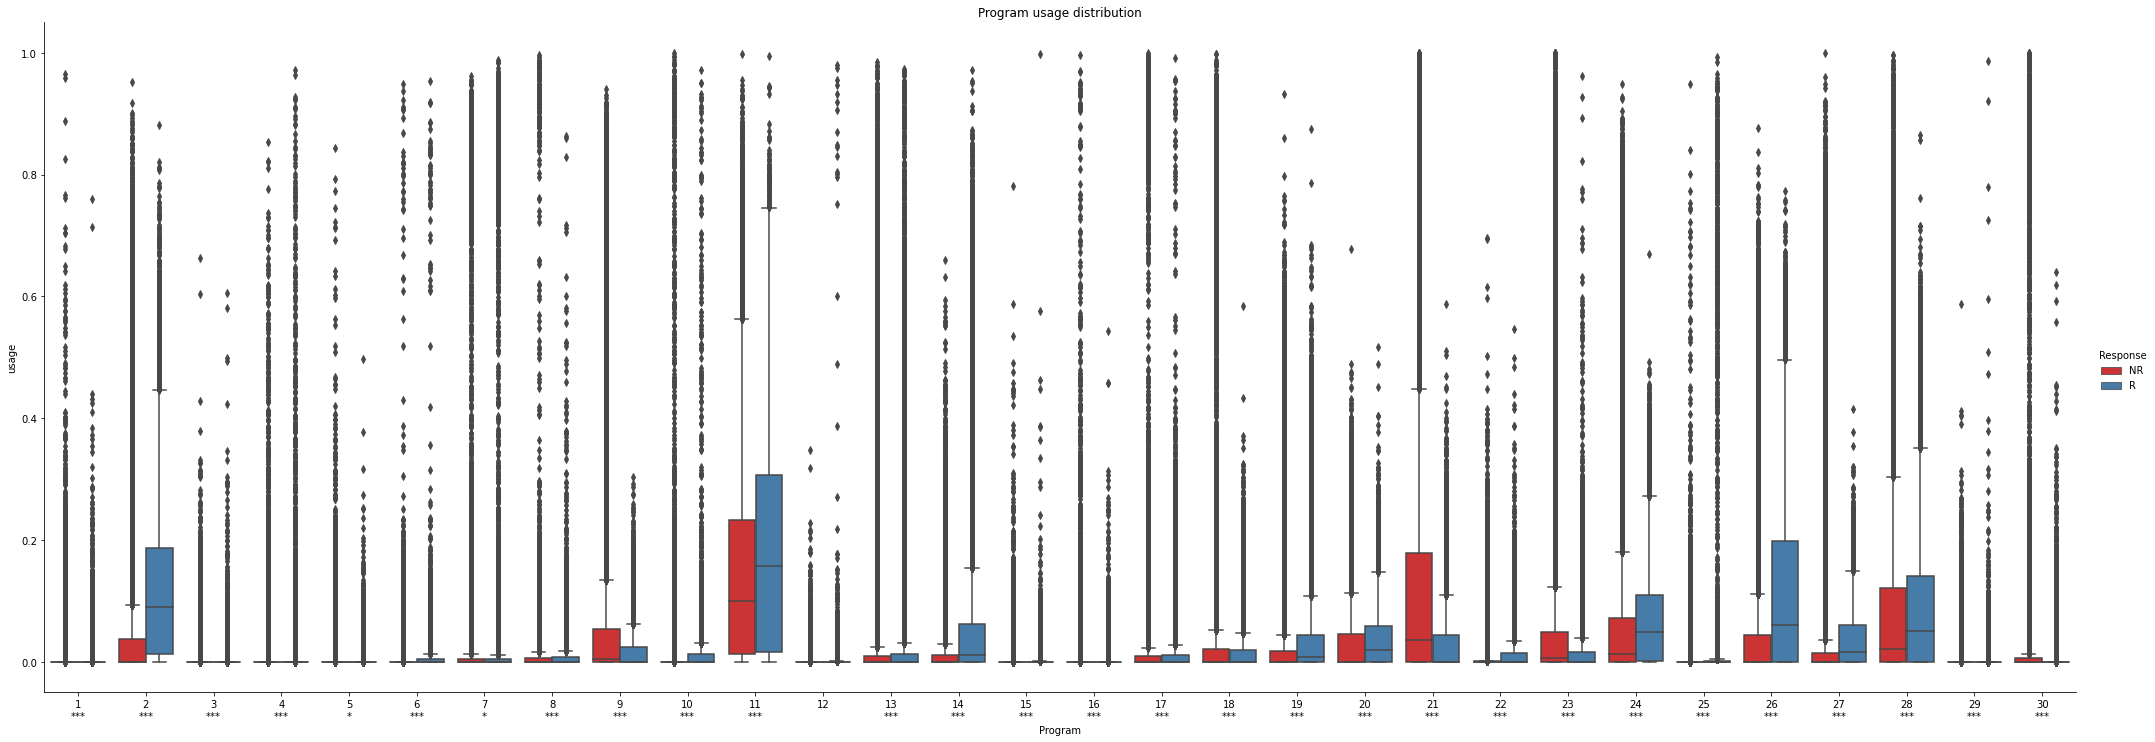

In [9]:
melt_fd = df.melt(id_vars=["sample","barcode", "Response"], var_name="program", value_name="usage")
melt_fd = melt_fd[melt_fd['Response']!='not in use for now']


pvals = np.zeros([selected_K, 2])
for i in range(1, selected_K+1):
    pvals[i-1, 1] = ranksums(melt_fd[(melt_fd.Response == 'R').values & (melt_fd.program == i).values].usage,
                         melt_fd[(melt_fd.Response == 'NR').values & (melt_fd.program == i).values].usage)[1]
    pvals[i-1, 0] = i

# Correct pvals
print(f'With corrected pvals!!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

def get_pval_asterisks(x ,p_value_dic):
    return str(x)+'\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if p_value_dic[x] < sig])
melt_fd['Program'] = melt_fd['program'].apply(lambda x: get_pval_asterisks(x, dict(corrected_pvals)))
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='usage', hue='Response', data=melt_fd, palette="Set1",height=10, aspect=2.9).set(title="Program usage distribution")

# print_pvals(pvals, N_PROG)

In [10]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)
# save_pvals(join(OUTPUT_PATH, 'GEP_usages_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'program')
# ax.savefig(join(OUTPUT_PATH, 'GEP_usages_ranksum_test.png'), dpi = 150)

### Only activity programs:

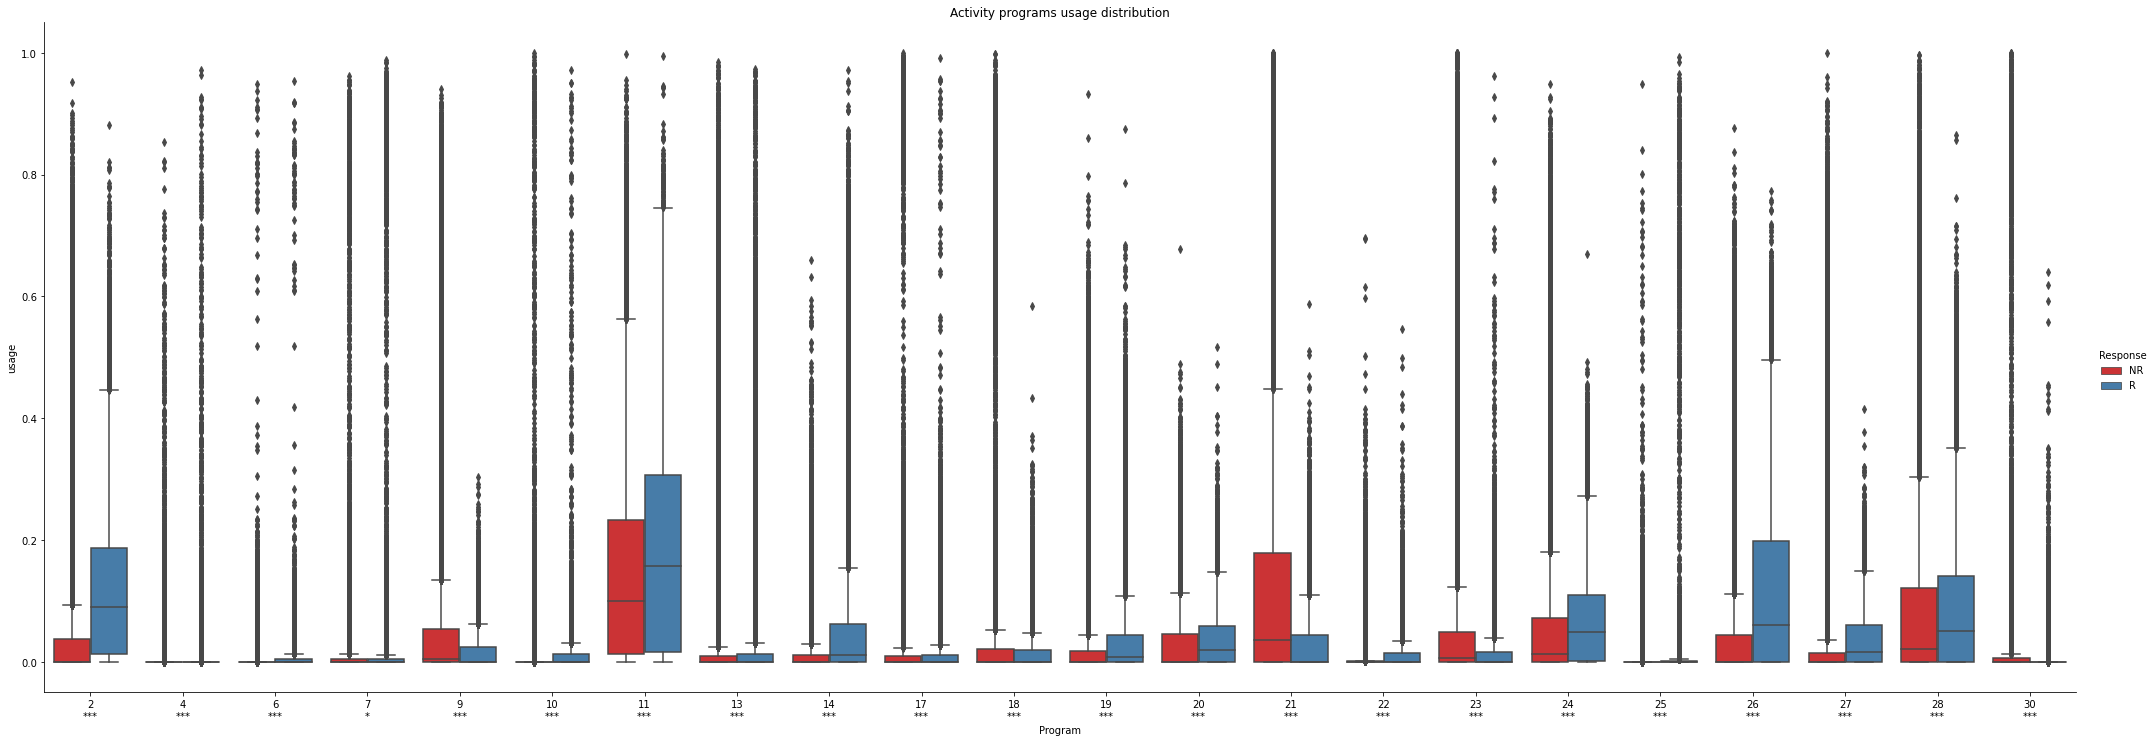

In [11]:
activity_melt_fd = melt_fd[melt_fd.program.isin(activity_programs_idx)]
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='usage', hue='Response', data=activity_melt_fd, palette="Set1",height=10, aspect=2.9).set(title="Activity programs usage distribution")

# int_prog_indxes = activity_programs_idx-1
# print_pvals(pvals[int_prog_indxes], N_PROG)

In [12]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# ax.savefig(join(OUTPUT_PATH, 'Activity_GEP_usages_ranksum_test.png'), dpi = 150)

# 4. GEP association with response (2)

Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


###### Loads usages:

In [13]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_4.11.21'#/k30_2000genes_200iter'
selected_K = 30
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '30'
N_PROG = 30
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [14]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
# keep only data of current patients in cohort
df = df[df['sample'].isin(res_melanoma_clinical_data.index.tolist())]
df['Response'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

df_r = df[df['Response']=='R']
df_nr = df[df['Response']=='NR']

##### Assign each cell one program based on the maximal usage value.

In [15]:
r_high_prog = np.argmax(df_r[list(range(1,N_PROG+1))].values, axis=1)+1
nr_high_prog = np.argmax(df_nr[list(range(1,N_PROG+1))].values, axis=1)+1

df_r.loc[:, 'associated program'] = r_high_prog
df_nr.loc[:, 'associated program'] = nr_high_prog

/Local/md_keren/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Local/md_keren/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


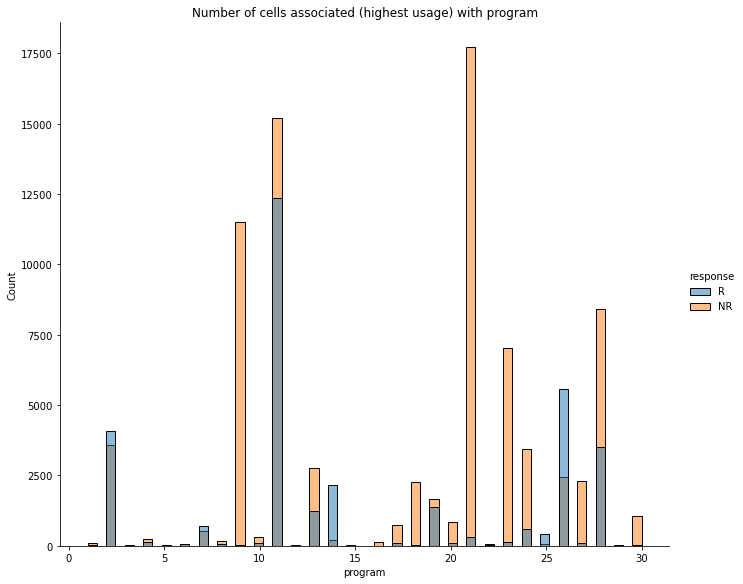

In [16]:
sns.reset_orig() 
ddd = pd.DataFrame(np.concatenate([r_high_prog, nr_high_prog]), columns=['program'])
ddd['response'] = ['R']*len(r_high_prog) + ['NR']*len(nr_high_prog)
sns.displot(data=ddd, x='program', hue='response', common_norm=False,height=8, aspect=1.2).set(title=f'Number of cells associated (highest usage) with program');

Conduct ranksum test:

In [17]:
r_associated_program_count_df = pd.DataFrame(df_r.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
r_samples = r_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in r_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  r_associated_program_count_df[r_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_r_patients_usage = {p: [samples_dic[sample][p]  for sample in r_samples] for p in range(1, selected_K+1)}



nr_associated_program_count_df = pd.DataFrame(df_nr.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
nr_samples = nr_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in nr_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  nr_associated_program_count_df[nr_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_nr_patients_usage = {p: [samples_dic[sample][p]  for sample in nr_samples] for p in range(1, selected_K+1)}

With corrected pvals!!


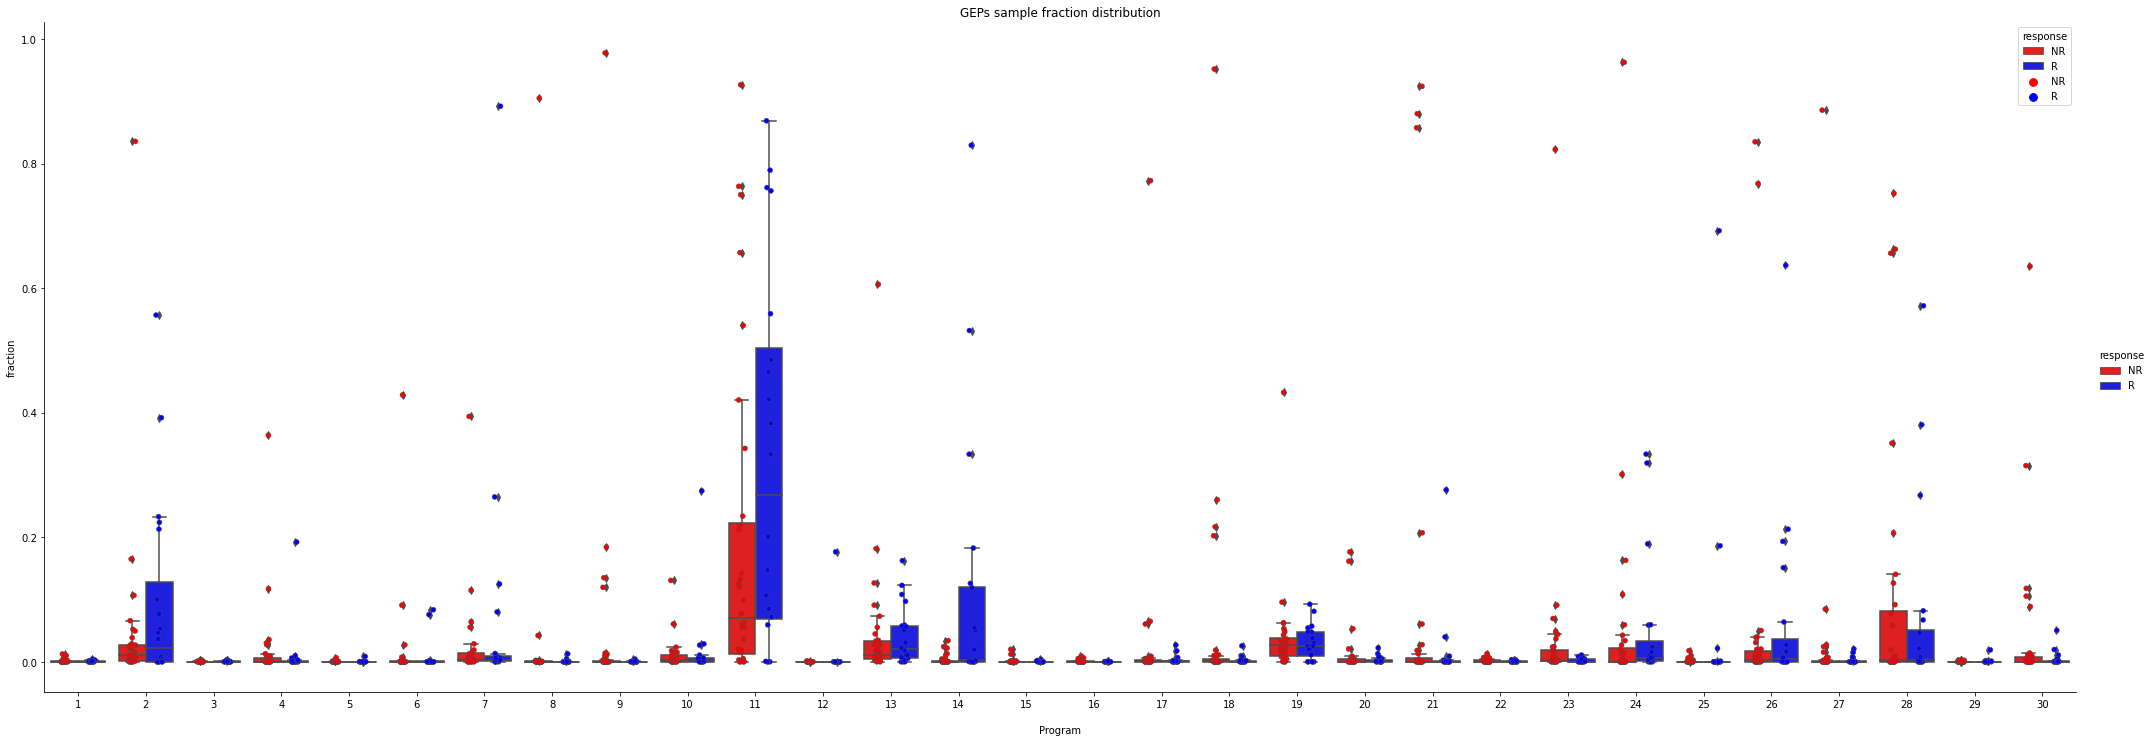

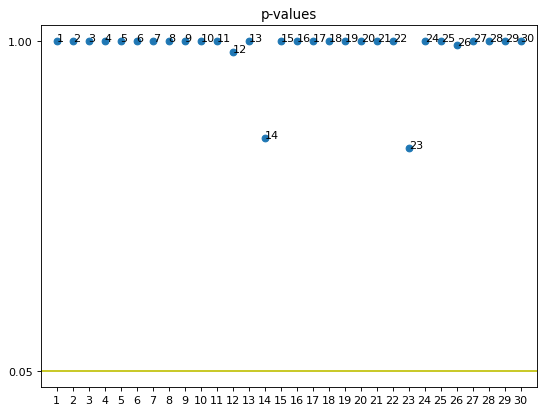

In [24]:
pvals = np.zeros([selected_K, 2])
for i in range(1, selected_K+1):
    pvals[i-1] = ranksums(programs_nr_patients_usage[i], programs_r_patients_usage[i])[1]
    pvals[i-1, 0] = i

# Correct pvals
print(f'With corrected pvals!!')
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T

programs_nr_patients_df = pd.DataFrame(programs_nr_patients_usage)
programs_nr_patients_df['response'] = 'NR'
programs_r_patients_df = pd.DataFrame(programs_r_patients_usage)
programs_r_patients_df['response'] = 'R'

fraction_df = programs_nr_patients_df.melt(id_vars=["response"], var_name="program", value_name="fraction").append(programs_r_patients_df.melt(id_vars=["response"], var_name="program", value_name="fraction"))

sns.reset_orig()
def get_pval_asterisks(x ,p_value_dic):
    return str(x)+'\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if p_value_dic[x] < sig])
fraction_df['Program'] = fraction_df['program'].apply(lambda x: get_pval_asterisks(x, dict(corrected_pvals)))
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='response', data=fraction_df, palette={'NR':'r', 'R':'b'},height=10, aspect=2.9).set(title="GEPs sample fraction distribution")
sns.stripplot(x='Program', y='fraction', hue='response', data=fraction_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
print_pvals(corrected_pvals, N_PROG)

In [19]:
GROUP_NAME = 'program'

pval_df = pd.DataFrame(np.array([pvals[:,0], pvals[:,1], corrected_pvals[:,1]]).T, columns=[GROUP_NAME, 'pval', 'corrected_pval'])#.sort_values('pval')
pval_df[GROUP_NAME] = pval_df[GROUP_NAME].astype(int)
pval_df.program.apply(lambda x: x in activity_programs_idx)
# pval_df.to_excel(path, index=False)
# activity_programs_idx
arr = np.array([1,2,4])
l = [1,4]
arr[np.isin(arr, l)]

array([1, 4])

In [25]:
# ax.savefig('/storage/md_keren/shitay/garbage/GEP_fraction_ranksum_test.png', dpi = 150)

In [20]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)
# save_pvals(join(OUTPUT_PATH, 'GEP_fraction_ranksum_test_pvals.xlsx'), pvals, corrected_pvals, 'program')
# ax.savefig(join(OUTPUT_PATH, 'GEP_fraction_ranksum_test.png'), dpi = 150)

### Present only activity programs:

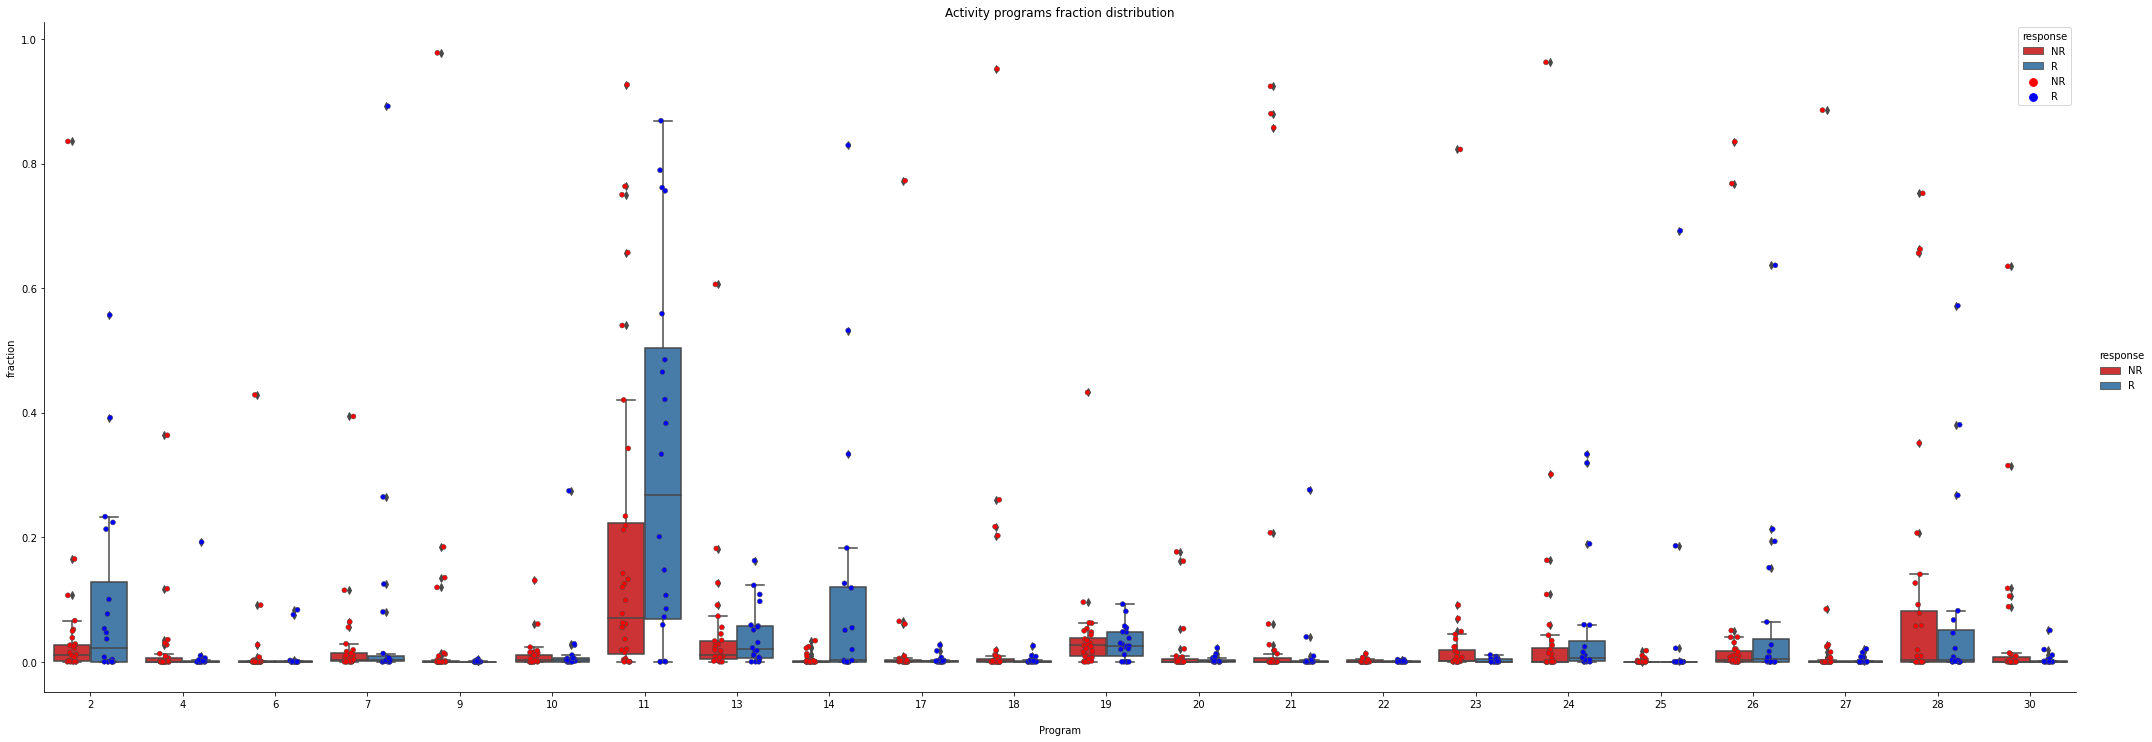

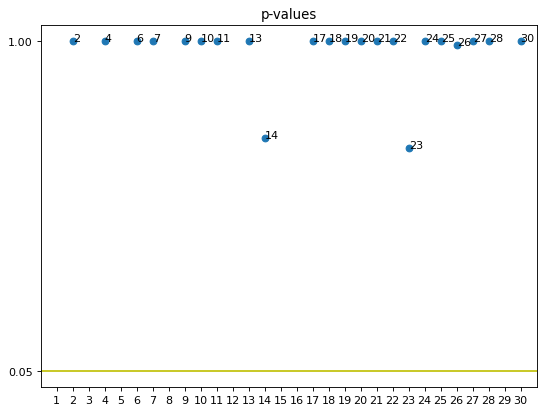

In [22]:
activity_fraction_df = fraction_df[fraction_df.program.isin(activity_programs_idx)]
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='response', data=activity_fraction_df, palette="Set1",height=10, aspect=2.9).set(title="Activity programs fraction distribution")
sns.stripplot(x='Program', y='fraction', hue='response', data=activity_fraction_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});

int_prog_indxes = activity_programs_idx-1
print_pvals(corrected_pvals[int_prog_indxes], N_PROG)

In [36]:
# OUTPUT_PATH = join(FOLDER_PATH, 'statistical_tests')
# create_folder(OUTPUT_PATH)

# ax.savefig(join(OUTPUT_PATH, 'Activity_GEP_fraction_ranksum_test.png'), dpi = 150)

Specify program and see the fraction of R/NR sorted:

In [37]:
# program_idx = 4

# patient_fractions = sorted([[x, 'R'] for x in programs_r_patients_usage[program_idx]] + [[x, 'NR'] for x in programs_nr_patients_usage[program_idx]])

# sns.reset_orig() # reset size of figure
# boxplot_df = pd.DataFrame(patient_fractions, columns=['prog_fraction', 'Response'])
# sns.catplot(x="Response", y="prog_fraction", data=boxplot_df, kind="box",height=5, aspect=1.2);


# print([x[1] for x in patient_fractions])
# patient_fractions

# 5. tSNE

In [87]:
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/subcohort_1.1.22/immune/immune_bhtsne_1.1.22.csv'
subcohort_tsne_df = pd.read_csv(TSNE_PATH)
curr_samples_tsne_df = subcohort_tsne_df[subcohort_tsne_df.Sample.isin(res_melanoma_clinical_data.index.tolist())]
other_samples_tsne_df = subcohort_tsne_df[~subcohort_tsne_df.Sample.isin(res_melanoma_clinical_data.index.tolist())]

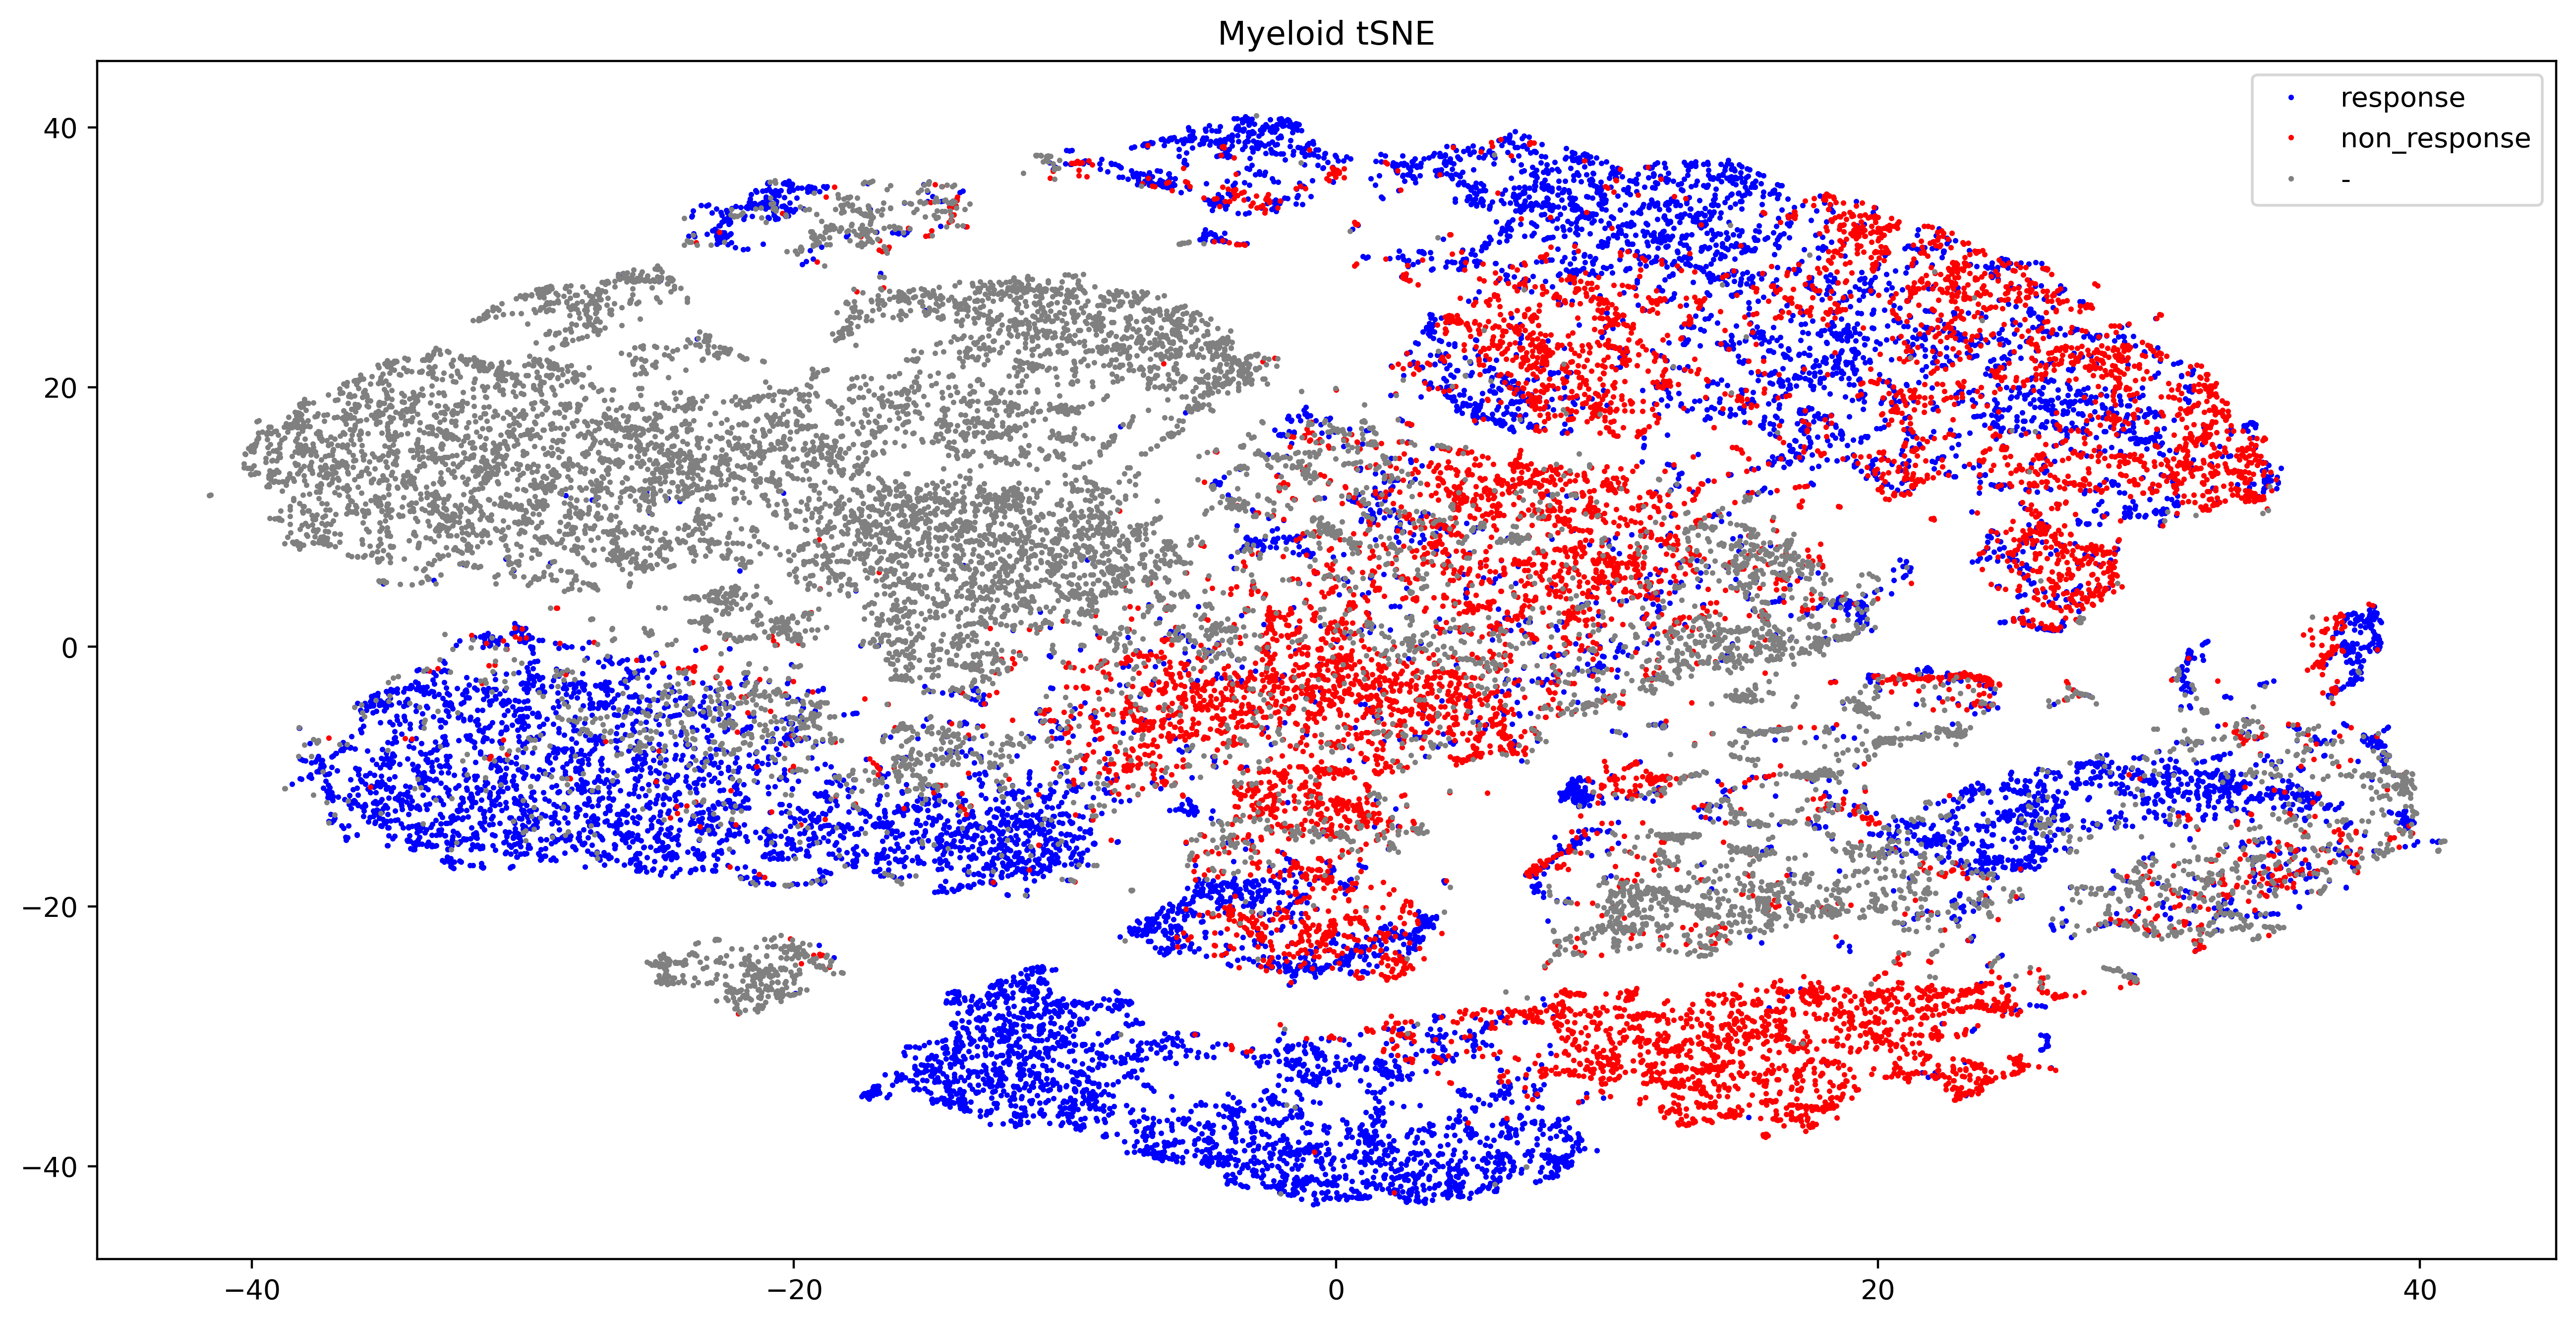

In [88]:
# plt.plot(Xi, Yi, 'ro', color=colors[cluster_idx], label=cluster_idx, markersize=1)

R_tsne_df = curr_samples_tsne_df[curr_samples_tsne_df.Sample.isin(response_samples)]
NR_tsne_df = curr_samples_tsne_df[curr_samples_tsne_df.Sample.isin(non_response_samples)]

plt.figure(figsize=(16, 8))
plt.plot(R_tsne_df[['x', 'y']].values[:,0], R_tsne_df[['x', 'y']].values[:,1], 'ro', color='b', label='response', markersize=1);
plt.plot(NR_tsne_df[['x', 'y']].values[:,0], NR_tsne_df[['x', 'y']].values[:,1], 'ro', label='non_response', markersize=1);
plt.plot(other_samples_tsne_df[['x', 'y']].values[:,0], other_samples_tsne_df[['x', 'y']].values[:,1], 'ro', color='gray', label='-', markersize=1);
plt.legend();
plt.title(f"Myeloid tSNE");

# Debug

In [7]:
### 30.8.2019  Nivo
#### 6.2.2020 Collected
### 13.7.2020 IPI + NIVO




True

In [ ]:
# # # cluster_idx = 11
# # for cluster_idx in range(12):
# #     display(n_barcodes_df[n_barcodes_df.Cluster==cluster_idx].sort_values('Barcode').reset_index(drop= True).tail(10))

sizes = [10, 30, 50, 100]


t_n_barcodes_df = n_barcodes_df[n_barcodes_df.Sample.isin(training_set['Patient id'])]


for cluster_idx in range(1, 13):
    cluster_n_barcodes_df = t_n_barcodes_df[t_n_barcodes_df.Cluster==cluster_idx].sort_values('Barcode').reset_index(drop= True)

    print(f'############### Cluster {cluster_idx} ###############')
    for size in sizes:
        print(f'min size: {size}')
        print(f'number of barcodes: {cluster_n_barcodes_df[cluster_n_barcodes_df.Barcode>size].groupby("Response").count().Barcode.values.sum()*size}')
        print(f'Number of sample: {cluster_n_barcodes_df[cluster_n_barcodes_df.Barcode>size].groupby("Response").count().Barcode.values.sum()}')
        print(f'Number of sample max group: {cluster_n_barcodes_df[cluster_n_barcodes_df.Barcode>size].groupby("Response").count().Barcode.values.max()}')
#         print(f'Number of N sample: {cluster_n_barcodes_df[cluster_n_barcodes_df.Barcode>size].groupby("Response").count().Barcode.values[1]}')
        print()